In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
bbg_prices = pd.read_excel("../data/Bloomberg_Prices.xlsx")
bbg_msci_prices = pd.read_excel(
    "../data/Bloomberg_Prices.xlsx", sheet_name="MSCI_World"
)
data_dict = pd.read_excel("../data/Data_dictionary.xlsx")
data_msci = pd.read_csv("../data/DataMSCI.csv", sep=";")

In [4]:
print(bbg_prices.shape)
print(bbg_msci_prices.shape)
print(data_dict.shape)
print(data_msci.shape)

(786, 1395)
(785, 2)
(9382, 10)
(1394, 60)


In [5]:
bbg_msci_prices.describe()

,Dates,MXWO Index
count,785,785.000000
mean,2023-05-16 23:59:59.999999744,3022.496930
min,2021-11-15 00:00:00,2367.690000
25%,2022-08-16 00:00:00,2757.970000
50%,2023-05-17 00:00:00,2964.240000
75%,2024-02-15 00:00:00,3274.330000
max,2024-11-15 00:00:00,3795.300000
std,NaN,347.863803


In [6]:
bbg_prices.describe()

,Dates,US1264081035,US1270971039,CA5592224011,US8326964058,US8425871071,US78409V1044,US5732841060,US2371941053,CA05534B7604,...,US83444M1018,CA0084741085,US09290D1019,CH1335392721,US5049221055,IE00028FXN24,US4385161066,US88160R1014,US31488V1070,IE000IVNQZ81
count,786,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,...,170.000000,786.000000,786.000000,142.000000,786.000000,96.000000,786.000000,786.000000,786.000000,786.000000
mean,2023-05-17 16:49:27.938931456,32.913893,26.114669,56.475802,133.149631,72.434924,400.704962,434.857837,147.256349,43.277684,...,62.786706,55.541781,746.015941,82.415354,212.885728,46.446146,198.209294,235.733259,159.389707,134.845763
min,2021-11-15 00:00:00,26.510000,19.000000,38.030000,106.920000,61.100000,286.620000,296.050000,111.840000,26.820000,...,48.020000,37.540000,531.100000,76.546300,175.508600,38.850000,166.970000,108.100000,102.180000,107.520000
25%,2022-08-16 06:00:00,31.025000,24.445000,50.897500,120.580000,67.730000,355.690000,355.475000,138.812500,37.130000,...,57.570000,48.335000,669.135000,77.723200,201.256250,44.577500,191.042500,190.087500,129.645000,124.392500
50%,2023-05-17 12:00:00,33.200000,25.915000,55.610000,132.835000,70.570000,392.305000,418.485000,148.110000,44.200000,...,63.155000,52.025000,733.640000,82.000000,211.600000,46.580000,197.950000,233.765000,154.560000,132.340000
75%,2024-02-15 18:00:00,34.595000,27.840000,61.082500,146.207500,75.690000,435.622500,518.302500,158.517500,48.877500,...,68.297500,60.257500,802.420000,86.500000,223.337500,48.780000,205.887500,268.377475,191.895000,144.707500
max,2024-11-18 00:00:00,38.380000,36.110000,89.340000,162.590000,94.150000,529.000000,621.530000,175.890000,59.020000,...,80.000000,88.850000,1053.840000,97.000000,269.929300,53.450000,233.910000,399.926700,223.850000,166.050000
std,NaN,2.493396,2.785273,10.423215,14.579889,6.983115,55.094308,91.361882,14.252908,7.208122,...,7.141992,11.117428,103.262152,4.047234,16.947574,3.285118,11.504763,57.251235,33.817950,12.986358


In [7]:
def preprocess_serie(prices):
    """
    change axe to Date and delete NaN values
    """
    prices["Dates"] = pd.to_datetime(prices["Dates"])
    prices.set_index("Dates", inplace=True)
    prices_clean = prices.dropna(axis=1, how="any")

    return prices_clean


def get_returns(prices):
    returns = prices.pct_change(fill_method=None).dropna()
    return returns

**Remark 4.** Portfolio decarbonization requires the covariance matrix \( \Sigma \) to be estimated. A first approach is to use the empirical covariance matrix of stock returns. A second solution is to postulate a multivariate risk factor model:

$$
R_i(t) = \alpha_i + B F(t) + \varepsilon_i(t)
$$

where $F(t)$ is the vector of risk factors and $\varepsilon_i(t)$ is the specific risk. By denoting $\Omega = \text{var}(F(t))$ and $ D = \text{var}(\varepsilon_1(t), \dots, \varepsilon_n(t)) = \text{diag}(\tilde{\sigma}_1^2, \dots, \tilde{\sigma}_n^2) $, we obtain

$$
\Sigma = B \Omega B^T + D
$$


1. **Calculer les rendements** des actions et de l'indice MSCI World. Cela permet de déterminer la variation des prix au fil du temps, ce qui est nécessaire pour les calculs de la covariance.

2. **Calculer la covariance** entre les rendements de chaque action et ceux de l'indice MSCI World pour comprendre la relation entre chaque actif et le marché.

3. **Formule de covariance** :

La covariance entre les rendements de l'action $ i $ et ceux du MSCI World est donnée par la formule suivante :

$$
\text{Cov}(R_i, R_m) = \frac{1}{n-1} \sum_{t=1}^{n} (R_i(t) - \bar{R_i})(R_m(t) - \bar{R_m})
$$

où $ R_i(t) $ est le rendement de l'action $ i $ au temps $ t $, et $ R_m(t) $ est le rendement de l'indice MSCI World au même moment.


In [8]:
returns = get_returns(preprocess_serie(bbg_prices)).iloc[:-1]
market_returns = get_returns(preprocess_serie(bbg_msci_prices))

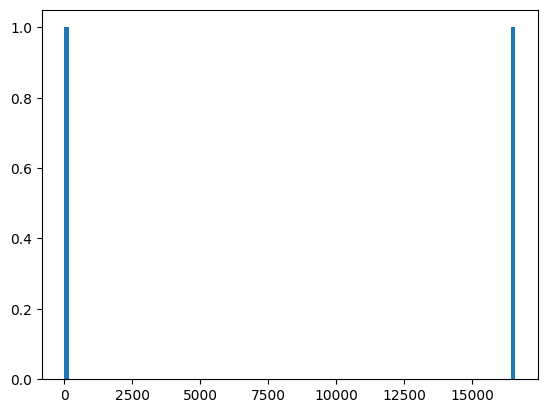

In [9]:
max_returns = returns.max(axis=1)

plt.hist(max_returns[max_returns > 0.0001 * max(max_returns)], bins=100)
plt.show()

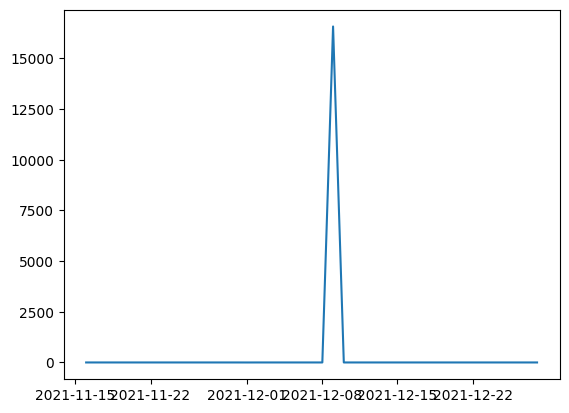

In [10]:
# We delete one firm

plt.plot(returns["IT0003492391"].iloc[:31])
returns = returns.drop(["IT0003492391"], axis=1)

**Problème** 
Dans le fichier bloomberg_prices, j'ai pas réussi à identitifer la colonne relative au MSCI World. Il faudra peut être demander à Ines


In [11]:
cov_with_market = [
    returns[col].cov(market_returns["MXWO Index"]) for col in returns.columns
]

print(len(cov_with_market))

1213


In [12]:
# Variance du MSCI World
msci_world_variance = market_returns.var()[0]

# Calcul des betas pour chaque action
betas = cov_with_market / msci_world_variance

# Covariance des facteurs (Omega)
omega = msci_world_variance

# Variance spécifique pour chaque action (D)
specific_variance = returns.var() - betas * omega

# Construction de la matrice de covariance à un facteur
# Matrice de covariance entre les actions basée sur le facteur (B * Omega * B.T)
factor_covariance = np.outer(betas, betas) * omega

# Matrice diagonale de variance spécifique (D)
specific_covariance = np.diag(specific_variance)

# Matrice totale de covariance (Sigma)
cov_matrix_sigma = factor_covariance + specific_covariance

# Afficher la matrice de covariance Sigma
print(cov_matrix_sigma)

[[2.09716114e-04 7.05530558e-05 1.33880185e-04 ... 1.80046961e-04
  1.00165271e-04 1.10168470e-04]
 [7.05530558e-05 4.55593378e-04 1.22828027e-04 ... 1.65183616e-04
  9.18963672e-05 1.01073776e-04]
 [1.33880185e-04 1.22828027e-04 5.93218962e-04 ... 3.13449401e-04
  1.74380862e-04 1.91795744e-04]
 ...
 [1.80046961e-04 1.65183616e-04 3.13449401e-04 ... 1.67418233e-03
  2.34513750e-04 2.57933919e-04]
 [1.00165271e-04 9.18963672e-05 1.74380862e-04 ... 2.34513750e-04
  3.58691887e-04 1.43496012e-04]
 [1.10168470e-04 1.01073776e-04 1.91795744e-04 ... 2.57933919e-04
  1.43496012e-04 2.97009393e-04]]


/var/folders/v5/_0ss5l5d6nz8d575gs5spbx40000gn/T/ipykernel_20675/1997017988.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  msci_world_variance = market_returns.var()[0]


<Axes: >

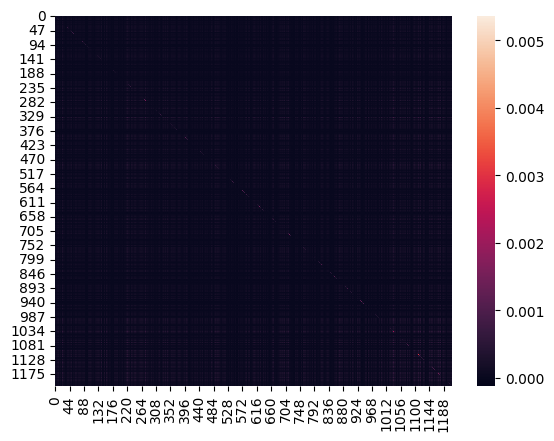

In [13]:
import seaborn as sns

sns.heatmap(cov_matrix_sigma)

<Axes: >

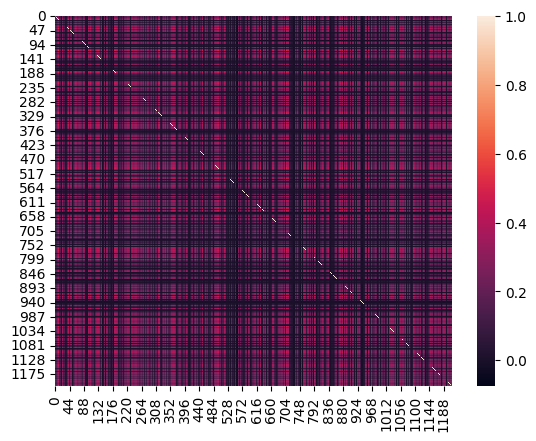

In [14]:
corr_matrix = cov_matrix_sigma / np.outer(
    np.sqrt(np.diag(cov_matrix_sigma)), np.sqrt(np.diag(cov_matrix_sigma))
)

sns.heatmap(corr_matrix)

0.0004701256741628606


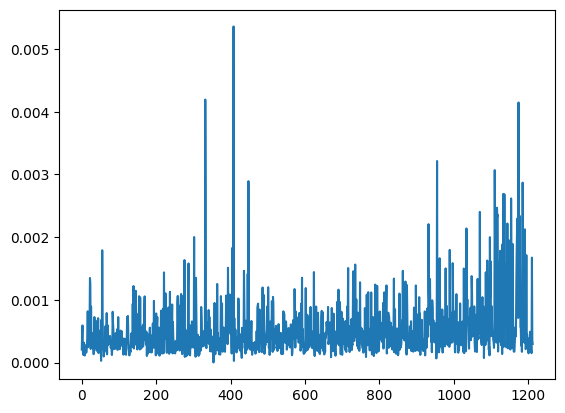

In [199]:
diag = [cov_matrix_sigma[i, i] for i in range(cov_matrix_sigma.shape[0])]

plt.plot(diag)
print(np.std(diag))